# Quickstart

In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import openml
from sklearn.model_selection import train_test_split
import pandas as pd

## Loading the dataset

This tutorial introduces you to a complete machine learning pipeline to run DRAGON for a simple classification task on the *PenDigits* dataset.

In [3]:
dataset = openml.datasets.get_dataset(32)
data, _, numerical, names = dataset.get_data()
data.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47.0,100.0,27.0,81.0,57.0,37.0,26.0,0.0,0.0,23.0,56.0,53.0,100.0,90.0,40.0,98.0,8
1,0.0,89.0,27.0,100.0,42.0,75.0,29.0,45.0,15.0,15.0,37.0,0.0,69.0,2.0,100.0,6.0,2
2,0.0,57.0,31.0,68.0,72.0,90.0,100.0,100.0,76.0,75.0,50.0,51.0,28.0,25.0,16.0,0.0,1
3,0.0,100.0,7.0,92.0,5.0,68.0,19.0,45.0,86.0,34.0,100.0,45.0,74.0,23.0,67.0,0.0,4
4,0.0,67.0,49.0,83.0,100.0,100.0,81.0,80.0,60.0,60.0,40.0,40.0,33.0,20.0,47.0,0.0,1


In [4]:
X = data.drop('class', axis=1)
y = data[["class"]].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Number of features: {X.shape[1]}, number of classes: {y.shape[1]}")

X_train: (7694, 16), y_train: (7694, 1), X_val: (3298, 16), y_val: (3298, 1)
Number of features: 16, number of classes: 1


In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y.values)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.y[index]
train_set = CustomDataset(X_train, y_train)
val_set = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

## Search Space

In **DRAGON** the neural networks are represented as *Directed Acyclic Graphs (DAGs)*, where each node represents `nn.Module` layer, and the edges are the connection between them. Within the package, the DAGs are encoded using their adjaceny matrix. To know more about these objects, refer to the [Search Space](docs/source/Examples/) section.

### Meta-Architecture

The meta-architecture $f$ should encompasses all the considered neural networks from the search space. To define a meta-architecture usable with **DRAGON**, we create a class that inherits from `nn.Module`. The __init__ should take as input arguments defining a certain set of architecture and hyperparameters $\{\alpha, \theta\}$. Then, the __forward__ function should take an input a variable $X$ and returns the prediction $\hat{y} = f_{\alpha,\theta}(X)$.

The main bricks to build neural networks within the **DRAGON** package are `dragon.search_space.cells.WeightsAdjCell` and `dragon.search_space.cells.Node`. The `WeightsAdjCell` creates a DAG and the `Node` a simple layer. Both bricks can be used to create models adapted to the task at hand. In this case we stay very simple with a single `WeightsAdjCell` embodying the neural network and a final `Node` to get the right output shape.

Before the first training of a given neural network, the layers should be initialized with the right input shape. This is done using the `dragon.search_space.cells.set_node` and `dragon.search_space.cells.set_cell` functions.

In [6]:
from dragon.search_space.cells import WeightsAdjCell, set_node, set_cell


class MetaArchi(nn.Module):
    def __init__(self, args, input_shape):
        super().__init__()
        # Number of features, here equals to 16
        self.input_shape = input_shape

        # We create the DAG using the WeightsAdjCell module
        set_cell(args['Dag'], self.input_shape)
        self.dag = WeightsAdjCell(args['Dag'])

        # We set the final layer
        self.output = args["Out"]
        set_node(self.output, self.dag.output_shape)

    def forward(self, X):
        out = self.dag(X)
        return self.output(out)
    
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)

### Arguments

The `MetaArchi` class takes as input a dictionnary `args` containing one search space configuration ${\alpha, \theta}$. We now need to define what values $\alpha$ and $\theta$ can take. To keep it simple, we will only use `nn.Linear` and `nn.Identity` layers as candidate operations. Several ready-to-use candidate operations are available within `dragon.search_space.variables`. They are then used to build Directed Acyclic Graphs.

In [7]:
from dragon.search_space.variables import mlp_var, identity_var, operations_1d_var, mlp_const_var, dag_var, node_var

candidate_operations = operations_1d_var("Candidate operations", size=10, candidates=[mlp_var("MLP"), identity_var("Identity")])
dag = dag_var("Dag", candidate_operations)
print(f'An example of a generated DAG: {dag.random()}')

# For the last layer, we do not want the number of output channels to be optimized. It should be equal to the number of classes.
out = node_var("Out", operation=mlp_const_var('Operation', 10), activation_function=nn.Softmax())

An example of a generated DAG: NODES: [
(combiner) add -- (name) <class 'dragon.search_space.bricks.basics.Identity'> -- (hp) {} -- (activation) Identity() -- , 
(combiner) concat -- (name) <class 'dragon.search_space.bricks.basics.MLP'> -- (hp) {'out_channels': 342} -- (activation) Tanh() -- ] | MATRIX:[[0, 1], [0, 0]]


With the elements `dag` and `out` we can generate composants to build a neural network.

In [8]:
args = {"Dag": dag.random(), "Out": out.random()}
model = MetaArchi(args, input_shape=(16,))

The final search space is an array which contain all the structural elements of the architecture as well as eventually other elements for the training for example.

In [9]:
from dragon.search_space.zellij_variables import ArrayVar
from dragon.search_algorithm.zellij_neighborhoods import ArrayInterval

search_space = ArrayVar(dag, out, label="Search Space", neighbor=ArrayInterval())

## Loss function

The search algorithm should minimize a certain loss function. Typically, it consists in training the model on a train set and then validate it on a validation set.

In [12]:
def train_model(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    model.train()
    for _ in range(10):
        for X,y in data_loader:
            optimizer.zero_grad()
            y = y.squeeze()
            pred = model(X)
            loss = loss_fn(pred,y)
            loss.backward()
            optimizer.step()
    return model

def test_model(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X, y in data_loader:
          y = y.squeeze(1)
          pred = model(X)
          loss = loss_fn(pred, y).item()
          test_loss += loss
          prediction = pred.argmax(axis=1)
          correct += (prediction == y).sum().item()
    accuracy = correct/ len(data_loader.dataset)
    return accuracy

def loss_function(args, *kwargs):
    labels = [e.label for e in search_space]
    args = dict(zip(labels, args))
    model = MetaArchi(args, input_shape=(16,))
    model = train_model(model, train_loader)
    accuracy = test_model(model, val_loader)
    return 1 - accuracy, model

loss, model = loss_function(search_space.random())
print(f'For a given argument, accuracy = {(1-loss)*100}%')

For a given argument, accuracy = 78.01697998787144%


# Search Algorithm

We can use several search algorithms to optimize the structures from the search space. Here, we take the example of the evolutionary algorithm.

In [13]:
from dragon.search_algorithm.ssea import SteadyStateEA

search_algorithm = SteadyStateEA(search_space, n_iterations=20, population_size=5, selection_size=3, evaluation = loss_function, save_dir="save/test")
min_loss = search_algorithm.run()

2024-09-20 15:55:09,108 | WARNING | Install mpi4py if you want to use the distributed version.
2024-09-20 15:55:09,112 | INFO | The whole population has been created (size = 5), models = 0
2024-09-20 15:55:09,112 | INFO | We start by evaluating the whole population (size=5)
2024-09-20 15:55:22,259 | INFO | Best found ! 0.8972104305639782 < inf
2024-09-20 15:55:29,371 | INFO | Best found ! 0.06882959369314734 < 0.8972104305639782
2024-09-20 15:56:07,081 | INFO | Best found ! 0.06064281382656156 < 0.06882959369314734
2024-09-20 15:56:07,086 | INFO | All models have been at least evaluated once, t = 5 < 20.
2024-09-20 15:56:07,110 | INFO | Evolving 1 and 0 to 6 and 7
2024-09-20 15:56:15,584 | INFO | Replacing 2 by 5
2024-09-20 15:56:15,588 | INFO | Best found ! 0.012128562765312267 < 0.06064281382656156
2024-09-20 15:56:28,515 | INFO | Evolving 5 and 4 to 8 and 9
2024-09-20 15:56:36,803 | INFO | Replacing 0 by 7
2024-09-20 15:56:36,808 | INFO | Best found ! 0.007580351728320167 < 0.012128

## Draw Graph

After the optimization, it is possible to load the best graph and draw the architecture.

Model giving a score of 99.27228623408126%:


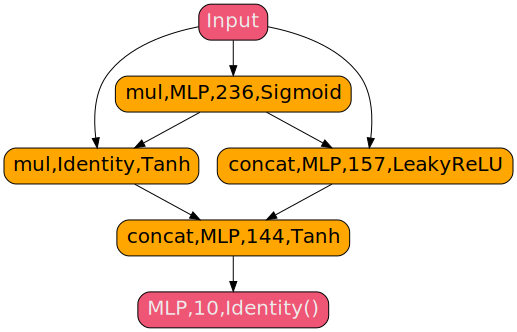

In [18]:
import graphviz
from dragon.utils.plot_functions import draw_cell, load_archi, str_operations

def draw_graph(n_dag, m_dag, output_file, act="Identity()", name="Input"):
    G = graphviz.Digraph(output_file, format='pdf',
                            node_attr={'nodesep': '0.02', 'shape': 'box', 'rankstep': '0.02', 'fontsize': '20', "fontname": "sans-serif"})

    G, g_nodes = draw_cell(G, n_dag, m_dag, "#ffa600", [], name_input=name,
                            color_input="#ef5675")
    G.node(','.join(["MLP", "10", act]), style="rounded,filled", color="black", fillcolor="#ef5675", fontcolor="#ECECEC")
    G.edge(g_nodes[-1], ','.join(["MLP", "10", act]))
    return G

best_model = load_archi("save/test/best_model/x.pkl")
labels = [e.label for e in search_space]
best_model = dict(zip(labels, best_model))
m_dag = best_model['Dag'].matrix
n_dag = str_operations(best_model["Dag"].operations)

graph = draw_graph(n_dag, m_dag, "save/test/best_archi")
print(f'Model giving a score of {(1-min_loss)*100}%:')
graph